In [419]:
import itertools, copy
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [3]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [390]:
def energy(s, h, Jk):
    energy = sum(h[c] for c in s)
    for k, J in enumerate(Jk):
        for i in range(len(s)-1-k):
            energy += J[s[i]][s[i+k+1]]
    return -energy

In [5]:
def expfamily(seq, lambdas, fs, Z=1):
    return np.exp(np.sum(lambdas*np.array([f(seq) for f in fs])))/Z

In [6]:
def create_counter(s):
    return lambda seq: seq.count(s)

In [7]:
symbols = aas
lambdas = np.zeros(len(aas))/len(aas)
fs = [create_counter(s) for s in list(symbols)]
abcd = expfamily('ABCD', lambdas, fs)

In [8]:
Z = sum(expfamily(s, lambdas, fs) for s in itertools.product(symbols, repeat=4))
print(Z, abcd/Z, 1/20**4)

160000.0 6.25e-06 6.25e-06


In [638]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
df0 = df0.set_index('seq')
humanaaprobdict = np.log(df0['freq']).to_dict()
humanaaprobdict

df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = (0.0*count).to_dict()

In [632]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log(count).to_dict()

In [422]:
h = humanaaprobdict
Jk = [humandoubletprobdict, copy.deepcopy(humandoubletprobdict)]

In [646]:
Z = np.exp(scipy.special.logsumexp([-energy(s, h, Jk) for s in itertools.product(symbols, repeat=5)]))

In [647]:
np.exp(-energy('AWAAL', h, Jk))/Z

6.618936608155473e-07

In [648]:
np.exp(loglikelihood_mc('AWAAL', humanaaprobdict, np.log(count).to_dict()))

6.140958010741882e-07

In [649]:
np.exp(loglikelihood_triplet('AWAAL', humanaaprobdict, np.log(count).to_dict(), humantripletprobdict))

6.351131833842131e-07

In [616]:
def mcmcsampler(x0, energy, jump, nsteps, nburnin=0, nsample=1):
    nsteps, nburnin, nsample = int(nsteps), int(nburnin), int(nsample)
    x = x0
    Ex = energy(x)
    states = []
    for i in range(nsteps):
        xp = jump(x)
        Exp = energy(xp)
        if np.random.rand() < np.exp(-Exp+Ex):
            x = xp
            Ex = Exp
        if (i > nburnin) and (i % nsample == 0):
            states.append(''.join(x))
    return np.array(states)

In [617]:
aas_arr = np.array(list(aas))

In [618]:
def jump(x):
    i = np.random.randint(0, len(x))
    x = list(x)
    x[i] = np.random.choice(aas_arr)
    return ''.join(x)

In [619]:
aafreqs = np.array(df0.loc[np.array(list(aas))]['freq'])
aafreqs /= np.sum(aafreqs)
jump = lambda x: ''.join(np.random.choice(np.array(list(aas)), size=6))
x0 = jump(None)
#x0 = ''.join(np.random.choice(np.array(list(aas)), size=4))
samples = mcmcsampler(x0, lambda x: energy(x, h, Jk), jump, 1e6)

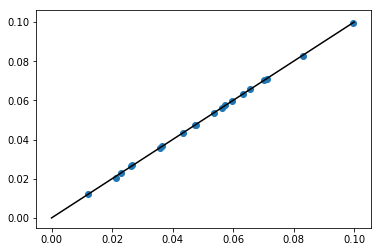

In [620]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])

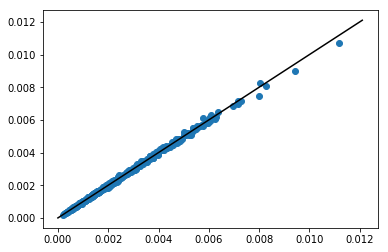

In [621]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])

In [622]:
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.020951538757612038

In [623]:
epsilon = 0.1
for idx, row in dfm1.iterrows():
    logfold = row['logfold']
    aa1 = row['seq'][0]
    aa2 = row['seq'][1]
    Jk[0][aa1][aa2] += logfold * epsilon

0.046836059325517064

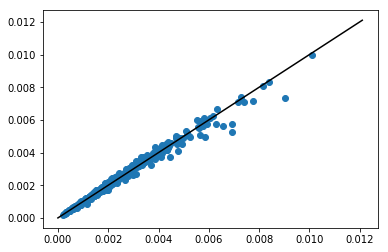

In [624]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

In [625]:
epsilon = 0.02
for idx, row in dfmgap1.iterrows():
    logfold = row['logfold']
    aa1 = row['seq'][0]
    aa2 = row['seq'][1]
    Jk[1][aa1][aa2] += logfold * epsilon